# Comparison with two-marginal solver

In [68]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 

from scipy.ndimage import gaussian_filter
import time

In [69]:

def plot_measures(measures, filename=None):

    fig, ax = plt.subplots(1, len(measures), figsize=(12,6),sharey=True)
    for i in range(len(measures)):
        ax[i].imshow(measures[i], origin='lower', extent=(0,1,0,1), cmap='Greys')
        ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i),fontsize=18)
        ax[i].set_xlabel('$x_1$',fontsize=18)
        ax[i].set_xticks([0,1])
        ax[i].set_yticks([0,1])

        ax[i].tick_params(axis='x',labelsize=14)
        ax[i].tick_params(axis='y',labelsize=14)

    ax[0].set_ylabel('$x_2$',fontsize=18)
    plt.subplots_adjust(wspace=0.08)

    if(filename is not None):
        plt.savefig(filename,bbox_inches='tight')
    plt.show()

## Simple circles

In [86]:
# Grid of size n1 x n2
n1 = 512   # x axis
n2 = 512   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

r = 0.125

positions = np.array([[0.2,0.8],
                      [0.4,0.6],
                      [0.6,0.4],
                      [0.8,0.2]])

# measures = [None]*len(positions)
measures = [None]*(len(positions))

for i in range(len(positions)):
    xc,yc = positions[i]
    measures[i] = np.zeros((n2, n1))
    measures[i][(x-xc)**2 + (y-yc)**2 < r**2] = 1

    # Normalize
    measures[i] *= n1*n2 / np.sum(measures[i])

    measures[i] = np.flipud(measures[i])


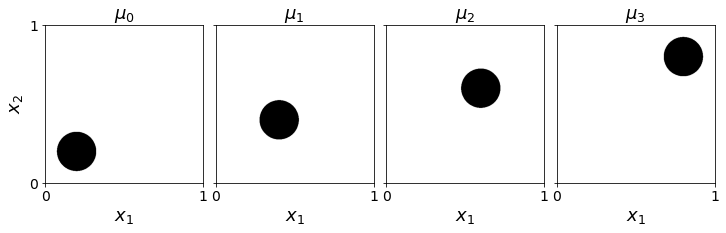

In [87]:
plot_measures(measures)

In [88]:
unroll_node = 0

edge_list = [[0,1],
             [1,2],
             [2,3]]
             
probMMOT = MMOTSolver(measures, edge_list, x, y, unroll_node)

start_time = time.time()
res = probMMOT.Solve(max_its=500, step_size=1.0, ftol_abs=1e-8, gtol_abs=3e-7)
print("--- %s seconds ---" % (time.time() - start_time))

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  7.8444e-02,   8.8557e-01,         2
       10,   0.0167,  1.1944e-01,   1.2100e-02,         0
       20,   0.0401,  1.1996e-01,   1.6971e-03,         0
       30,   0.0963,  1.2001e-01,   6.1696e-05,         0
       40,   0.1157,  1.2003e-01,   1.6741e-04,         0
       50,   0.0116,  1.2003e-01,   2.8193e-04,         4
       60,   0.0186,  1.2003e-01,   7.3690e-06,         1
       61,   0.0093,  1.2003e-01,   2.7048e-06,         1
Terminating due to small change in objective.
--- 12.923924207687378 seconds ---


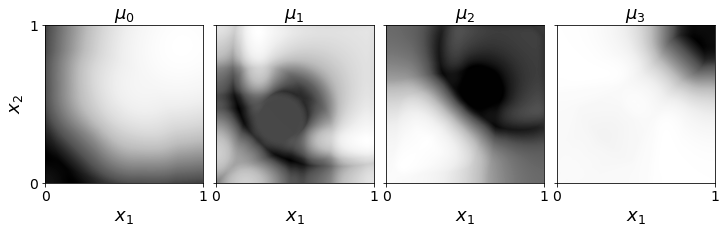

0.12003088328348338

In [105]:
plot_measures(res.dual_vars)
probMMOT.ComputeCost(res.dual_vars)

In [104]:
bfm_res = [None]*(len(measures)-1)
bfm_dual_vars = [None]*len(measures)
for i in range(len(measures)):
    bfm_dual_vars[i] = np.zeros((n2, n1))

manual_cost = 0.0
start_time = time.time()
for i in range(len(measures)-1):
    prob = MMOTSolver(measures[i:i+2], [[0,1]], x, y, 0)
    bfm_res[i] = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-12, gtol_abs=1e-7)
    bfm_dual_vars[i] += bfm_res[i].dual_vars[0]
    bfm_dual_vars[i+1] += bfm_res[i].dual_vars[1]
    manual_cost += prob.ComputeCost(bfm_res[i].dual_vars)

print('MMOT Cost: ', np.sum([r.costs[-1] for r in bfm_res]), ' vs ', res.costs[-1])
print("--- %s seconds ---" % (time.time() - start_time))

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  3.2476e-02,   3.4092e-01,         2
       10,   0.0111,  4.0024e-02,   4.0951e-06,         2
       20,   0.0000,  4.0024e-02,   4.2492e-06,         3
       22,   0.0000,  4.0024e-02,   4.2493e-06,         3
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  3.2286e-02,   3.0504e-01,         2
       10,   0.0667,  3.9982e-02,   1.3715e-05,         0
       20,   0.0000,  3.9983e-02,   9.0152e-06,         4
       20,   0.0000,  3.9983e-02,   9.0152e-06,         4
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.2500,  3.2826e-02,   3.2791e-01,         2
       10,   0.0167,  4.0024e-02,   6.7798e-06,         0
       20,   0.0007,  4.0024e-02,   5.1981e-06,         5
       24,   0.0000,  4.0024e-02,   5.2415e-06,         4
Terminating due to small change in obj

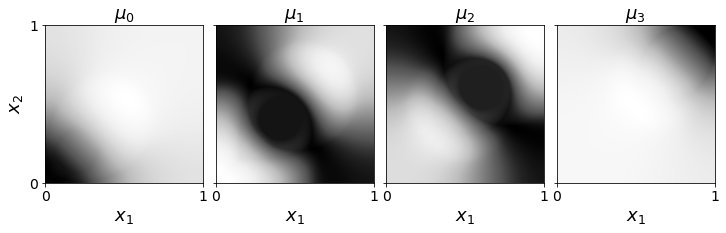

0.12003110570772607

In [106]:
plot_measures(bfm_dual_vars)
probMMOT.ComputeCost(bfm_dual_vars)

In [53]:
plt=plot_measures(bfm_dual_vars-res.dual_vars)

AttributeError: 'NoneType' object has no attribute 'subplots'

## More Complicated Marginals

In [107]:
def sharpen(img):
    blurred = gaussian_filter(img, sigma=7)
    
    blurred[blurred<0.5*np.max(blurred)] = 0.0
    blurred[blurred>0] = 1.0

    blurred /= np.sum(blurred)
    return blurred

def pad(img,pad_size=4):
    temp = np.ones((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
    temp[pad_size:-pad_size,pad_size:-pad_size] = img
    return temp

def rescale(img):
    output = np.zeros((2*img.shape[0],2*img.shape[1]))
    output[0::2,0::2] = img 
    output[1::2,0::2] = img 
    output[1::2,1::2] = img 
    output[0::2,1::2] = img 

    return output


In [108]:
measures = [None]*4
measures[0] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/redcross.png')[:, :, 2])))))
measures[1] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/tooth.png')[:, :, 2])))))
measures[2] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/heart.png')[:, :, 2])))))
measures[3] = sharpen(rescale(rescale(rescale(1 - pad(plt.imread('images/duck.png')[:, :, 2])))))

for i in range(len(measures)):
    measures[i] *= np.prod(measures[i].shape)/np.sum(measures[i])
   
print('Marginal size = ', measures[0].shape)

# Grid of size n1 x n2
n1,n2 = measures[0].shape

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

Marginal size =  (1088, 1088)


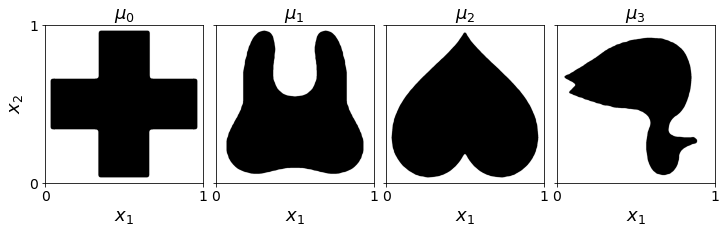

In [109]:
plot_measures(measures)

In [110]:
MMOTprob = MMOTSolver(measures, edge_list, x, y, unroll_node)

start_time = time.time()
res = MMOTprob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-6, gtol_abs=1e-7)
print("--- %s seconds ---" % (time.time() - start_time))

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.1250,  6.7821e-03,   1.3447e-01,         3
       10,   0.2109,  3.1393e-02,   1.4980e-03,         0
       20,   0.4746,  3.1838e-02,   9.5377e-05,         0
       30,   1.0000,  3.1890e-02,   1.7271e-05,         0
       30,   1.0000,  3.1890e-02,   1.7271e-05,         0
Terminating due to small change in objective.
--- 40.95962715148926 seconds ---


In [ ]:
plot_measures(res.dual_vars)
probMMOT.ComputeCost(res.dual_vars)

### Two-Marginal Solve

In [40]:

bfm_res = [None]*(len(measures)-1)
start_time = time.time()
for i in range(len(measures)-1):
    prob = MMOTSolver(measures[i:i+2], [[0,1]], x, y, 0)
    bfm_res[i] = prob.Solve(max_its=500, step_size=1.0, ftol_abs=1e-12, gtol_abs=1e-8)

print('MMOT Cost: ', np.sum([r.costs[-1] for r in bfm_res]), ' vs ', res.costs[-1])
print("--- %s seconds ---" % (time.time() - start_time))

Iteration, StepSize,        Cost,        Error,  Line Its
        0,   1.0000,  3.9277e-03,   1.7696e-02,         0
       10,   0.5625,  6.9856e-03,   5.5898e-05,         0
       20,   1.0000,  6.9891e-03,   3.3346e-07,         0
       30,   1.0000,  6.9895e-03,   1.7784e-07,         0
       40,   0.3560,  6.9897e-03,   1.4233e-07,         1
       50,   0.0422,  6.9897e-03,   1.4873e-07,         1
       60,   0.0100,  6.9897e-03,   1.4910e-07,         1
       70,   0.0024,  6.9897e-03,   1.4902e-07,         1
       80,   0.0006,  6.9897e-03,   1.4900e-07,         1
       90,   0.0001,  6.9897e-03,   1.4900e-07,         1
       96,   0.0001,  6.9897e-03,   1.4899e-07,         1
Terminating due to small change in objective.
Iteration, StepSize,        Cost,        Error,  Line Its
        0,   1.0000,  1.6247e-03,   3.9726e-03,         0
       10,   0.0527,  2.1492e-03,   5.1514e-06,         4
       20,   0.0625,  2.1494e-03,   6.7772e-07,         4
       30,   0.1406,  2.14